In [1]:
import time 
from keras.losses import SparseCategoricalCrossentropy
import tensorflow_model_optimization as tfmot
import Neural_Network_Tools.tools as nnt
import os 
import tensorflow as tf
from keras.models import load_model, save_model
quantize_model = tfmot.quantization.keras.quantize_model

NUM_OF_CLASSES = 3


In [2]:
(train_data, train_labels),(test_data, test_labels) = nnt.prepare_train_test_dataset()

In [15]:
def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

def quantization(baseline_model_path, train_data, train_labels, test_data, test_labels, batch_size, epochs, store_path):

  # create store path for models
  create_dir(store_path)

  # load baseline model from model path
  new_model = load_model(baseline_model_path)

  # evalute current baseline model accuracy
  _, baseline_model_accuracy = new_model.evaluate(test_data, test_labels, verbose=0)
  print('Original model test accuracy:', baseline_model_accuracy)

  # store it again: there are some problems with model overwriting, so store it again
  keras_file = os.path.join(store_path, "baseline_model.h5")
  tf.keras.models.save_model(new_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  # q_aware stands for for quantization aware.
  q_aware_model = quantize_model(new_model)

  # `quantize_model` requires a recompile.
  q_aware_model.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # q_aware_model.summary()

  train_images_subset = train_data[0:20000] 
  train_labels_subset = train_labels[0:20000]

  quanzized_model_history = q_aware_model.fit(train_images_subset, train_labels_subset,
                    batch_size=batch_size, epochs=epochs, validation_split=0.1)

  nnt.plot_history(quanzized_model_history,epochs, os.path.join(store_path,"history_quantized_fnn_model"))
  
  baseline_model_accuracy = new_model.evaluate(test_data, test_labels, verbose=0)[1]

  q_aware_model_accuracy = q_aware_model.evaluate(test_data, test_labels, verbose=0)[1]

  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Quant test accuracy:', q_aware_model_accuracy)

  quantized_keras_file = os.path.join(store_path,"quantized_model.h5")
  save_model(q_aware_model, quantized_keras_file, include_optimizer=False)
  print('Saved pruned model to:', quantized_keras_file)

  converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  quantized_tflite_model = converter.convert()

  quantized_tflite_file = os.path.join(store_path, "quantized_tflite_model.tflite")

  with open(quantized_tflite_file, 'wb') as f:
    f.write(quantized_tflite_model)

  print('Saved pruned TFLite model to:', quantized_tflite_file)

  print("Size of gzipped baseline Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(keras_file)))
  print("Size of gzipped quantized Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(quantized_keras_file)))
  print("Size of gzipped quantized TFlite model: %.2f bytes" % (nnt.get_gzipped_model_size(quantized_tflite_file)))


  return quantized_tflite_model, q_aware_model_accuracy

In [16]:
import numpy as np

def evaluate_model(interpreter, test_data, test_labels):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # test_labels = np.argmax(test_labels, axis=1)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_sample in enumerate(test_data):
    # if i % 1000 == 0:
    #   print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_sample = np.expand_dims(test_sample, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_sample)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

Original model test accuracy: 0.9941359758377075
Saved baseline model to: Quantization\baseline_model.h5
Epoch 1/15
141/141 [==============================] - 2s 6ms/step - loss: 0.1435 - accuracy: 0.9596 - val_loss: 0.1087 - val_accuracy: 0.9645
Epoch 2/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0801 - accuracy: 0.9693 - val_loss: 0.0665 - val_accuracy: 0.9710
Epoch 3/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0682 - accuracy: 0.9740 - val_loss: 0.0616 - val_accuracy: 0.9795
Epoch 4/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0673 - accuracy: 0.9744 - val_loss: 0.0781 - val_accuracy: 0.9685
Epoch 5/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0607 - accuracy: 0.9777 - val_loss: 0.0388 - val_accuracy: 0.9880
Epoch 6/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0653 - accuracy: 0.9754 - val_loss: 0.0867 - val_accuracy: 0.9715
Epoch 7/15
141/141 [=======================

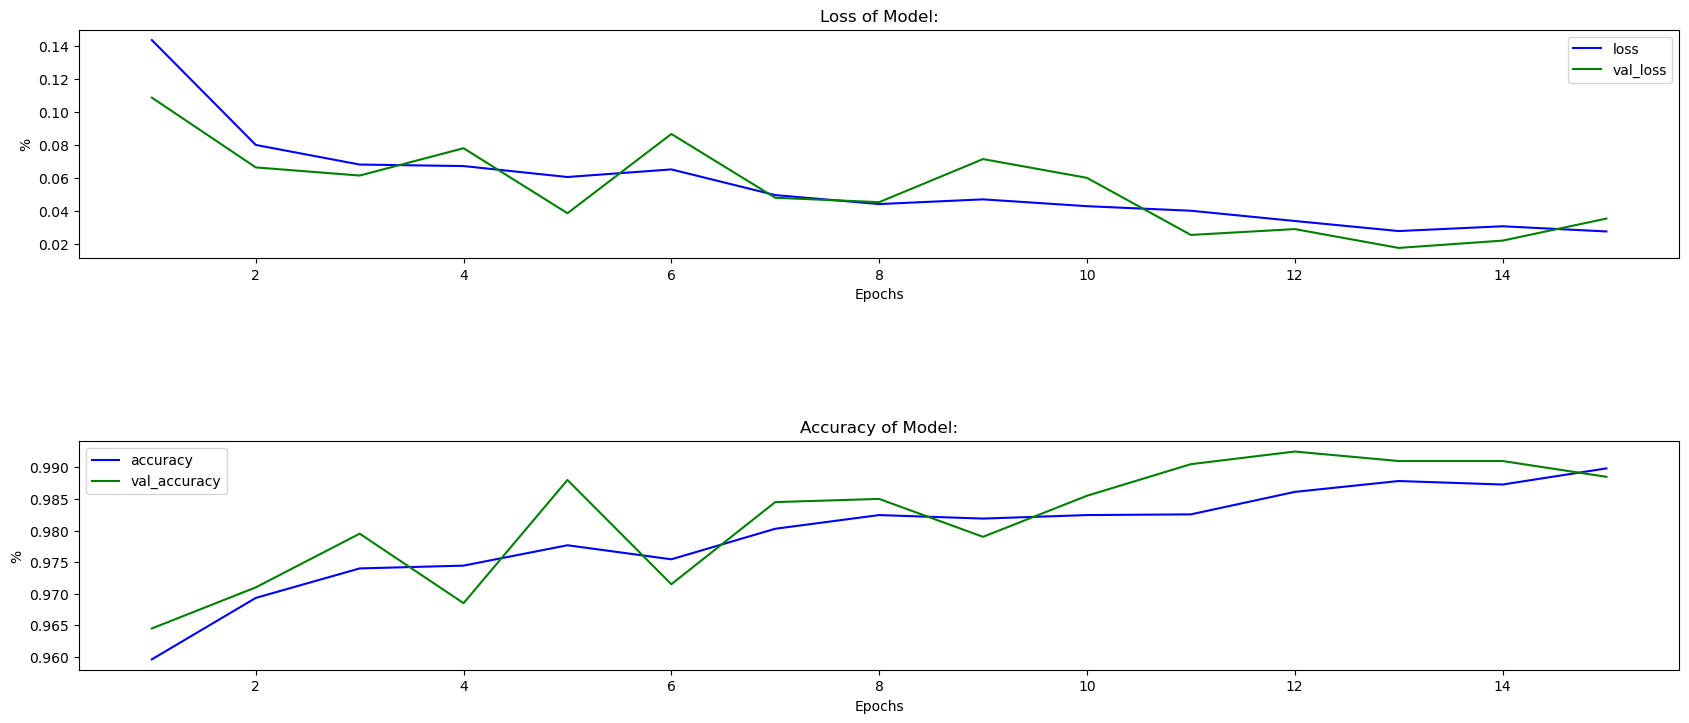

Baseline test accuracy: 0.9941359758377075
Quant test accuracy: 0.9902439117431641
Saved pruned model to: Quantization\quantized_model.h5


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpemalbrlx\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpemalbrlx\assets
c:\Users\sandr\anaconda3\envs\Converter\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Saved pruned TFLite model to: Quantization\quantized_tflite_model.tflite
Size of gzipped baseline Keras model: 290012.00 bytes
Size of gzipped quantized Keras model: 292348.00 bytes
Size of gzipped quantized TFlite model: 55254.00 bytes


In [17]:
quantized_tflite_model, q_aware_model_accuracy = quantization("fnn_model.h5", train_data, train_labels, test_data, test_labels, 128, 15, "Quantization")

In [18]:
import time
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter, test_data, test_labels)

print('Quant TF test accuracy:', q_aware_model_accuracy)
print('Quant TFLite test_accuracy:', test_accuracy)



Quant TF test accuracy: 0.9902439117431641
Quant TFLite test_accuracy: 0.990295796574987
